In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.random import randn, uniform
import scipy.stats

In [2]:
def create_uniform_particles(x_range, y_range, theta_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(theta_range[0], theta_range[1], size=N)
    return particles

In [3]:
def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

In [4]:
def predict(particles, u, std, dt=1.0):
    N = len(particles)
    particles[:, 2] += u[0] * dt + randn(N) * std[0]
    particles[:, 2] %= 2 * np.pi
    dist = u[1] * dt + randn(N) * std[1]
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

In [5]:
def update(particles, weights, z, R, landmarks):
    weights.fill(1.)
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])
    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In [6]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [7]:
def systematic_resample(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

In [8]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.fill(1.0 / len(weights))

In [9]:
def estimate(particles, weights):
    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

In [10]:
def run_pf(N, iters=18, sensor_std_err=0.1, do_plot=True, plot_particles=False, xlim=(0, 20), ylim=(0, 20), initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12, 14], [18, 21]])
    NL = len(landmarks)
    plt.figure()
    
    if initial_x is not None:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0, 20), (0, 20), (0, 2 * np.pi), N)
    
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000) / np.sqrt(N)
        plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color='g')

    xs = []
    robot_pos = np.array([0., 0.])
    
    for _ in range(iters):
        robot_pos += (1, 1)
        zs = norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err)
        predict(particles, u=(0.00, 1.414), std=(0.2, 0.05))
        update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)

        if neff(weights) < N / 2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
        
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+', color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('Final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

Final position error, variance:
	 [-0.11050622  0.10956331] [0.00902346 0.00813228]


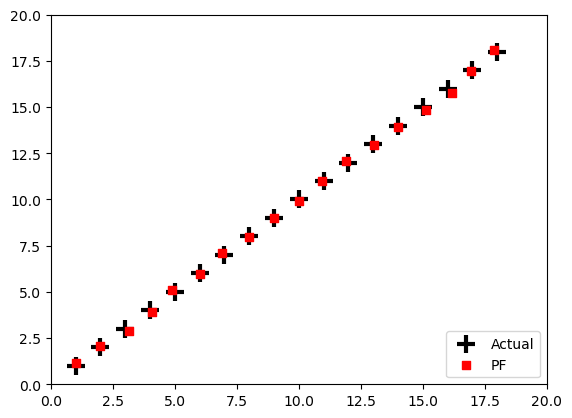

In [11]:
# Run the particle filter
from numpy.random import seed
seed(2)
run_pf(N=5000, plot_particles=False)

Final position error, variance:
	 [-0.11050622  0.10956331] [0.00902346 0.00813228]


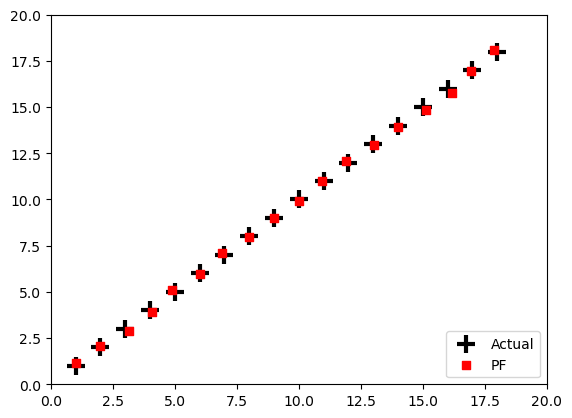

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.random import randn, uniform
import scipy.stats

def create_uniform_particles(x_range, y_range, theta_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(theta_range[0], theta_range[1], size=N)
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    return particles

def predict(particles, u, std, dt=1.0):
    N = len(particles)
    particles[:, 2] += u[0] * dt + randn(N) * std[0]
    particles[:, 2] %= 2 * np.pi
    dist = u[1] * dt + randn(N) * std[1]
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

def update(particles, weights, z, R, landmarks):
    weights.fill(1.)
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])
    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

def systematic_resample(weights):
    N = len(weights)
    positions = (np.arange(N) + np.random.random()) / N
    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.fill(1.0 / len(weights))

def estimate(particles, weights):
    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

def run_pf(N, iters=18, sensor_std_err=0.1, do_plot=True, plot_particles=False, xlim=(0, 20), ylim=(0, 20), initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12, 14], [18, 21]])
    NL = len(landmarks)
    plt.figure()
    
    if initial_x is None:
        particles = create_uniform_particles((0,20), (0,20), (0,2*np.pi), N)
    else:
        particles = create_gaussian_particles(mean=initial_x, std=(5, 5, np.pi/4), N=N)
    
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000) / np.sqrt(N)
        plt.scatter(particles[:, 0], particles[:, 1], alpha=alpha, color='g')

    xs = []
    robot_pos = np.array([0., 0.])
    
    for _ in range(iters):
        robot_pos += (1, 1)
        zs = norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err)
        predict(particles, u=(0.00, 1.414), std=(0.2, 0.05))
        update(particles, weights, z=zs, R=sensor_std_err, landmarks=landmarks)

        if neff(weights) < N / 2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
        
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+', color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('Final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

# Run the particle filter
from numpy.random import seed
seed(2)
run_pf(N=5000, plot_particles=False)